Notebook to build 2 layer neural network from scratch and with Keras

# Project definition

Predict if a patient with diabetes will be readmitted to the hospital within 30 days. 

In [10]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
import pickle

In [11]:
cols_input= pickle.load(open('../data/cols_input.sav','rb'))

In [12]:
# load the data
df_train_all = pd.read_csv('../data/df_train_all.csv')
df_train = pd.read_csv('../data/df_train.csv')
df_valid = pd.read_csv('../data/df_valid.csv')

In [13]:
#make X matrices
X_train_all = df_train_all[cols_input].values
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train[['OUTPUT_LABEL']].values
y_valid = df_valid[['OUTPUT_LABEL']].values

X_train.shape, y_train.shape

((15766, 143), (15766, 1))

# Feature Engineering

Most of the feature engineering was completed in our prior project (https://github.com/andrewwlong/diabetes_readmission), but we need to fill in missing values and scale our features. For simplicity, we will fill missing values with the mean and scale the data to zero mean and unit variance. 

In [14]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean.fit(X_train_all)

SimpleImputer()

In [15]:
X_train_all_tf = imp_mean.transform(X_train_all)
X_train_tf = imp_mean.transform(X_train)
X_valid_tf = imp_mean.transform(X_valid)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_all_tf)

StandardScaler()

In [17]:
X_train_all_tf = scaler.transform(X_train_all_tf)
X_train_tf = scaler.transform(X_train_tf)
X_valid_tf = scaler.transform(X_valid_tf)


# From Scratch

In [18]:
len(cols_input)

143

Here we would like to build a simple two-layer neural network from scratch using the structure introduced by Eric Ma:
    - Model
    - Loss function
    - Optimization Routine
    
For notation, I will try to stick to the notation introduced by Andrew Ng in his Coursera specialization (https://www.coursera.org/specializations/deep-learning). 

# Model

The model we will use is a two-layer neural network as shown below:
    ![title](../img/model.png)

Here we will have n_x input variables, n_1 hidden nodes and an output node. For this model we will use logistic regression $\sigma(z)$ for the hidden and output nodes. 

$\sigma(z) = \frac{1}{1-exp(-z)}$

In [19]:
def logistic(z):
    # vectorized logistic function
    return 1 / (1 + np.exp(-z))

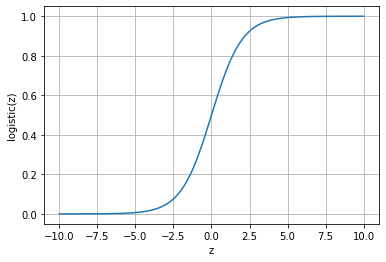

In [20]:
z = np.linspace(-10,10,1000)
plt.plot(z, logistic(z),'-')
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.grid(True)
plt.show()

Our logistic model will follow the form:

$a = \sigma(z)$
where $z = W X + b$

Here we will use vectorized notation for more efficient algorithms. 

In this notation, the first column of X will be all of features for a single sample. 

Here, let's say we have `m` samples. 

The parameters we will use for this model with dimensions in curly braces are:

$W^{[1]} \quad \{n_1, n_x \}$

$b^{[1]} \quad \{n_1, 1 \}$

$W^{[2]} \quad \{1, n_1 \}$

$b^{[2]} \quad \{1, 1 \}$

Let's initialize our parameters in a dictionary with random inputs.

In [21]:
nx = len(cols_input)
print(nx)

143


Let's choose 64 hidden nodes:

In [22]:
n1 = 64

In [23]:
params = dict()
params['W1'] = np.random.randn(n1,nx)
params['b1'] = np.random.randn(n1,1)
params['W2'] = np.random.randn(1,n1)
params['b2'] = np.random.randn(1,1)

The equations (with dimensions in curly braces) we need to calculate our $\hat{y}$ (estimate of y) are:

$A^{[0]} = X \quad \{n_x,m\}$

$Z^{[1]} = W^{[1]} A^{[0]} + b^{[1]} \quad \{n_1, m\}$

$A^{[1]} = \sigma(Z^{[1]}) \quad \{n_1, m\}$

$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]} \quad \{ 1,m \}$

$A^{[2]} = \sigma(Z^{[2]}) \quad \{ 1,m \}$

$\hat{Y} = A^{[2]} \quad \{ 1,m \}$

Let's define a feedforward function that allows us to calculate all the As. Here will assume that X has features as columns and rows as samples. Andrew Ng's notation transposes this which we can do in this feedforward function. 

In [24]:
def feedforward_2layer(params, act, X):
    # feedforward equations for 2 layer neural network using activation function act for hidden layer
    
    
    
    #input layer
    A0 = X.T # transpose for consistency with Andrew Ng
    # hidden layer
    Z1 = np.dot(params['W1'], A0) + params['b1']
    A1 = act(Z1)
    # output layer
    Z2 = np.dot(params['W2'], A1) + params['b2']
    A2 = logistic(Z2)

    # make a dictionary of values
    ff = dict()
    ff['A0'] = A0 
    ff['A1'] = A1
    ff['A2'] = A2
    ff['Z1'] = Z1
    ff['Z2'] = Z2
    return ff

In [25]:
X_train_tf.shape

(15766, 143)

In [26]:
ff = feedforward_2layer(params, logistic, X_train_tf)

In [27]:
ff['A0'].shape

(143, 15766)

In [28]:
ff['A1'].shape

(64, 15766)

In [29]:
ff['Z1'].shape

(64, 15766)

In [30]:
ff['A2'].shape

(1, 15766)

In [31]:
ff['Z2'].shape

(1, 15766)

# Loss Function

Now we would like to find the 'best' weights W1, b1, W2, and b2. In order to define 'best', we create a cost function to define how good the weights are. The loss function we use for binary classification problems is:

$J = - \frac{1}{m} (\sum_{i=1}^{m} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i))$

Super obvious, right? 

I prefer to see where this comes from, so let's take a short detour. If we think about the output of our model as a probability of y given data x, we can write the following for a single sample:

For $y_i = 1, P(y_i|x_i) = \hat{y}_i$

For $y_i = 0, P(y_i|x_i) = 1 - \hat{y}_i$

This can be written in a slightly more complicated manner as

$ P(y_i|x_i) = (\hat{y}_i)^{y_i} (1-\hat{y}_i)^{1-y_i}$

Assuming independent samples, the probability of seeing all of our data is the product:
    
$Likelihood = P(y|x) = \Pi_{i=1}^{m} (\hat{y}_i)^{y_i} (1-\hat{y}_i)^{1-y_i}$

Now all we have to do is find the parameters that maximize this probability (an equation also called the likelihood function)! That sounds quite complicated given this has the product term. Fortunately, maximizes the log of this likelihood function also maximizes this likelihood function. When we take the log, we convert the product into a sum.

Before we do this, let's remind ourselves of a property of logs:

$\log(a^b c^d) = b \log(a) + d \log(c)$

$log(Likelihood )= \sum_{i=1}^{m} y_i \log(\hat{y}_i) +  (1-y_i) \log(1-\hat{y}_i)$

To turn this into our Cost function above, all we need to do is multiply by a negative sign (switching the maximization problem into a minimization problem). To be consistent with Andrew Ng, we will also divide by $m$. 

In [32]:
def logistic_loss(Y_hat, Y):
    # calculate the logistic loss
    return -np.sum(Y*np.log(Y_hat)+(1-Y)*np.log(1 - Y_hat))/Y.shape[1]

In [33]:
logistic_loss(ff['A2'], y_train.T) # note we have to transpose Y for consistent dimensions

2.9501469190173273

For our optimization routines, we will need the derivative of $J$ with respect to each parameter. 

Eric did this with the python package jax.grad

`dlogistic_loss = grad(logistic_loss)`

but I would like to write this out explicitly. 

To do this derivative, we actually work from right to left in our neural network. A process known as `back propagation`. We can do this with chain rule. 

$dZ^{[2]} := \frac{d J}{d Z^{[2]}} = \frac{dJ}{dA^{[2]}} \frac{dA^{[2]}}{dZ^{[2]}}$

Some useful properties of derivatives are:

$\frac{d log(x)}{dx} = \frac{1}{x}$

$\frac{d \exp(x)}{dx} = \exp(x)$

$\frac{d (1/x)}{dx} = \frac{-1}{x^2}$

Linearity of the derivative:

$\frac{d (\sum x_i(w))}{w} = \sum \frac{d x_i(w)}{d w}$

Since our cost sums over each sample, for now let's just drop the notation for each sample from the calculations (and the 1/m multiplier): 

$\frac{dJ}{dA^{[2]}} = -\frac{y}{A^{[2]}} +  \frac{1-y}{1-A^{[2]}}$

$\frac{dA^{[2]}}{dZ^{[2]}} = \frac{-\exp(-Z^{[2]})}{(1-\exp(-Z^{[2]}))^2} = (\frac{1}{1-\exp(-Z^{[2]})})(1 - \frac{1}{1-\exp(-Z^{[2]})}) = \sigma(Z^{[2]}) (1 - \sigma(Z^{[2]}) = A^{[2]} (1 - A^{[2]})$

$dZ^{[2]} := \frac{d J}{d Z^{[2]}} = (-\frac{y_i}{A^{[2]}} +  \frac{1-y_i}{1-A^{[2]}}) (A^{[2]} (1 - A^{[2]}))$

$ = -(1 - A^{[2]}) y +  A^{[2]}(1-y)$

$ = A^{[2]}-y$

To get the derivative with respect to each of the parameters we have (using correct matrix math)

$db^{[2]} := \frac{d J}{d b^{[2]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{db^{[2]}} = \frac{1}{m}\sum_{i = 1}^{m} d Z^{[2]}_i$

$dW^{[2]} := \frac{d J}{d W^{[2]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{dW^{[2]}} = \frac{1}{m} dZ^{[2]}A^{[1]} .^T$

To move beyond the final layer, we can actually write a generic activation function $g^{[l]}(z)$ instead of $\sigma(z)$

$dZ^{[1]} := \frac{dJ}{dZ^{[1]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{dZ^{[1]}} = W^{[2]}.^T dZ^{[2]} \frac{dA^{[1]}}{dZ^{[1]}} =  W^{[2]}.^T dZ^{[2]} * g'^{[1]} (Z^{[1]})$

where $g'$ denotes the derivative of the activation function.

$dW^{[1]} := \frac{1}{m}\frac{dJ}{dW^{[1]}} = \frac{1}{m}\frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{dW^{[1]}}= \frac{1}{m}dZ^{[1]} A^{[0]}.^T$

$db^{[1]} := \frac{d J}{d b^{[1]}} = \frac{dJ}{dZ^{[2]}} \frac{dZ^{[2]}}{db^{[1]}} = \frac{1}{m}\sum_{i = 1}^{m} d Z^{[1]}_i$

Using symmetry, we can also write the equations for any hidden layer

In [34]:
y_train.T.shape[1]

15766

In [35]:
def backprop_layer2(params, act_prime, ff,Y):
    # backpropagation using derivative of activation function act_prime with feedforward cache ff
    
    m = Y.shape[1]
    dZ2 = ff['A2'] - Y
    db2 = np.sum(dZ2, axis = 1, keepdims = True)/m
    dW2 = np.dot(dZ2, ff['A1'].T)/m
    
    dZ1 = np.dot(params['W2'].T, dZ2) * act_prime(ff['Z1']) # elementwise multiplication
    db1 = np.sum(dZ1, axis = 1, keepdims = True)/m
    dW1 = np.dot(dZ1, ff['A0'].T)/m
    
    backprop = dict()
    backprop['b2'] = db2
    backprop['W2'] = dW2
    backprop['b1'] = db1
    backprop['W1'] = dW1
    return backprop
    

In [36]:
def d_logistic(z):
    return logistic(z) * (1-logistic(z))

In [37]:
d_params = backprop_layer2(params, d_logistic, ff, y_train.T)

In [38]:
params['b1'].shape, d_params['b1'].shape

((64, 1), (64, 1))

In [39]:
params['W1'].shape, d_params['W1'].shape

((64, 143), (64, 143))

In [40]:
params['b2'].shape, d_params['b2'].shape

((1, 1), (1, 1))

In [41]:
params['W2'].shape, d_params['W2'].shape

((1, 64), (1, 64))

# Optimization Routine

Here we will use gradient descent, which basically says update the parameters by some learning rate $\alpha$ by going the opposite direction of the gradient. 

In [42]:
from tqdm.notebook import tqdm

In [43]:
alpha = 0.1
params = dict()
params['W1'] = np.random.randn(n1,nx)
params['b1'] = np.random.randn(n1,1)
params['W2'] = np.random.randn(1,n1)
params['b2'] = np.random.randn(1,1)

losses = []

ff = feedforward_2layer(params, logistic, X_train_tf)
losses.append(logistic_loss(ff['A2'], y_train.T)) # note we have to transpose Y for consistent dimensions    
for ii in tqdm(range(2000)):
    d_params = backprop_layer2(params, d_logistic, ff, y_train.T)
    for name, value in d_params.items():
        params[name] = params[name] - alpha*value
    ff = feedforward_2layer(params, logistic, X_train_tf)
    loss = logistic_loss(ff['A2'], y_train.T)
    if (ii % 100) == 0:
        print(ii,':',loss)
    losses.append(loss) # note we have to transpose Y for consistent dimensions

  0%|          | 0/2000 [00:00<?, ?it/s]

0 : 3.083894034316609
100 : 1.0898369776921397
200 : 0.9011537639380764
300 : 0.8133817348789404
400 : 0.7642935469065658
500 : 0.7333116458180058
600 : 0.7124747005974156
700 : 0.6979916259157195
800 : 0.687717013989354
900 : 0.6803090289713646
1000 : 0.6748874523984741
1100 : 0.6708611340901766
1200 : 0.6678269287358538
1300 : 0.6655062281038342
1400 : 0.6637040088889449
1500 : 0.6622820686365622
1600 : 0.6611413472418499
1700 : 0.6602101092089413
1800 : 0.6594359370634476
1900 : 0.6587802304285174


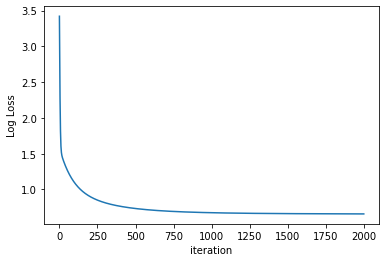

In [44]:
plt.plot(losses,'-')
plt.xlabel('iteration')
plt.ylabel('Log Loss')
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [46]:
ff_train = feedforward_2layer(params, logistic, X_train_tf)
y_train_preds = ff_train['A2'].T
ff_valid = feedforward_2layer(params, logistic, X_valid_tf)
y_valid_preds = ff_valid['A2'].T

/tmp/ipykernel_8112/347514560.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


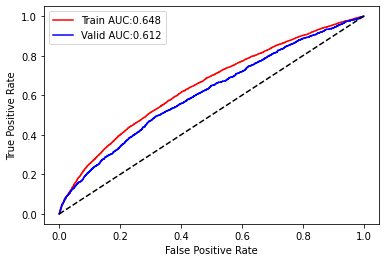

In [47]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)


plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Well that was quite slow to train. Let's use Keras (a deep learning framework) that has additional optimization routines like Adam which are faster. Keras is also great for building the neural network in just a few lines of code. 

# Keras

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

In [49]:
# make y labels that work nicely with Keras
y_train_keras = to_categorical(y_train,2)
y_valid_keras = to_categorical(y_valid,2)

y_train_keras.shape

(15766, 2)

In [50]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(64, activation = 'relu', 
                input_dim = X_train_tf.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(2, activation = 'softmax'))

2021-10-23 17:23:28.957265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-23 17:23:28.957307: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-23 17:23:28.957344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thuytrangnugget-ThinkPad-T430): /proc/driver/nvidia/version does not exist


In [51]:
# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [52]:
model.fit(X_train_tf, y_train_keras, 
          batch_size = 32, epochs= 5, 
          verbose = 1)

2021-10-23 17:23:29.148053: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
493/493 [==============================] - 1s 2ms/step - loss: 0.7260 - accuracy: 0.5743
Epoch 2/5
493/493 [==============================] - 1s 1ms/step - loss: 0.6656 - accuracy: 0.6074
Epoch 3/5
493/493 [==============================] - 1s 1ms/step - loss: 0.6521 - accuracy: 0.6194
Epoch 4/5
493/493 [==============================] - 1s 1ms/step - loss: 0.6463 - accuracy: 0.6274
Epoch 5/5
493/493 [==============================] - 1s 1ms/step - loss: 0.6425 - accuracy: 0.6329


In [55]:
y_train_preds_keras = model.predict(X_train_tf,verbose = 1)[:,1]
y_valid_preds_keras = model.predict(X_valid_tf,verbose = 1)[:,1]

466/466 [==============================] - 0s 945us/step


In [56]:
print('Train');
print_report(y_train[:,0], y_train_preds_keras, thresh=0.5)
print('Valid');
print_report(y_valid[:,0], y_valid_preds_keras, thresh=0.5);

Train
AUC:0.705
accuracy:0.647
recall:0.599
precision:0.662
specificity:0.695
prevalence:0.500
 
Valid
AUC:0.661
accuracy:0.649
recall:0.580
precision:0.178
specificity:0.658
prevalence:0.113
 


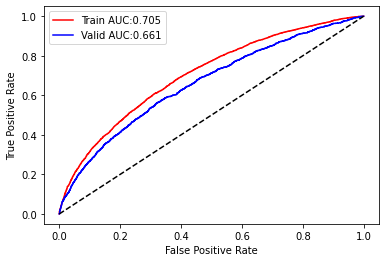

In [57]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds_keras)
auc_train = roc_auc_score(y_train, y_train_preds_keras)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds_keras)
auc_valid = roc_auc_score(y_valid, y_valid_preds_keras)


plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()